# **ARIMA (AutoRegressive Integrated Moving Average) Implementation**

We attempt to predict the closing price of NVDA from the period 2022-10-24 to 2022-11-04 using ARIMA model

ARIMA is a combination of an autoregressive (AR) model which regresses on its own lagged values as well as a moving average (MA) model which "regresses" on past forecast errors

$$(1-\phi_1B-...-\phi_pB^p)(1-B)^dy_t=c+(\theta_1B+...+\theta_qB^q)\epsilon_t$$

where $B$ is the backshift operator, that is $By_t = y_{t-1}$

Hyperparameters that require estimation:
- p: the order of AR which represents how many lagged values $y_{t-i}$ the AR model regresses on
- d: the order of differencing which represents the number of differencing required to make the time series stationary
- q: the order of MA which represents how many past forecast errors $\epsilon_{t-i}$ the MA model regresses on

In [ ]:
# install relevant libraries
!pip install statsmodels 
!pip install pmdarima
!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 18.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


## Importing Data
We use the `yfinance` library to download data on NVDA stock
- The data is further processed by taking only the 'Close' column which the variable we are attempting to forecast

[*********************100%***********************]  1 of 1 completed


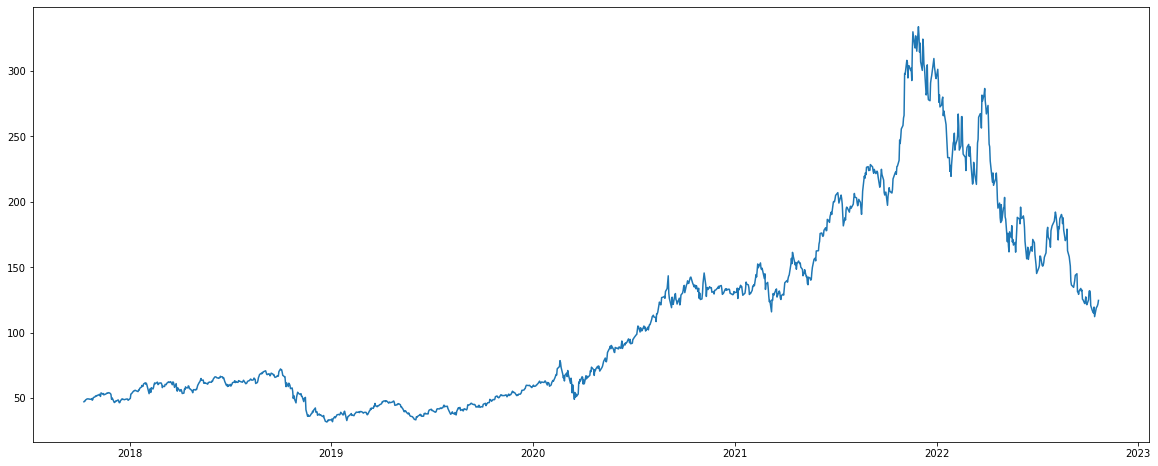

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.rcParams["figure.figsize"] = (20,8)
nvda = yf.Ticker('NVDA')
df = yf.download('NVDA', start='2017-10-10', end='2022-10-22')
df.index = pd.to_datetime(df.index)
df = df[['Close']]
plt.plot(df)

## Determining value of $d$
We will be determining the values of $p$ and $q$ via a gridsearch on the basis of the Corrected Akaike's Information Criterion
- Information criteria may be used as a means of comparing ARIMA models with varying $p$ and $q$ values, however we are not able to compare across different values of $d$ since the order of differencing fundamentally changes the data that the model is being fitted on

Thus there is a need to adopt other means to determine the order of differencing. Here we use the inbuilt `ndiffs` method to determine the minimum order of differencing required to make the time series stationary.
- However a more empirical and manual approach would be to iteratively difference the data and plot the ACF or conduct a unit root test such as the Augmented Dickey Fuller (ADF) or Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test to discern stationarity of the time series

In [ ]:
from pmdarima.arima import ndiffs
ndiffs(df['Close'], test='adf')

1

## Train-Test Split
From the initial time plot, we see that the close price of NVDA experienced the most significant increase in the past 2-3 years, thus we will be first restricting the data to the past 3 years then taking a 80-20 split

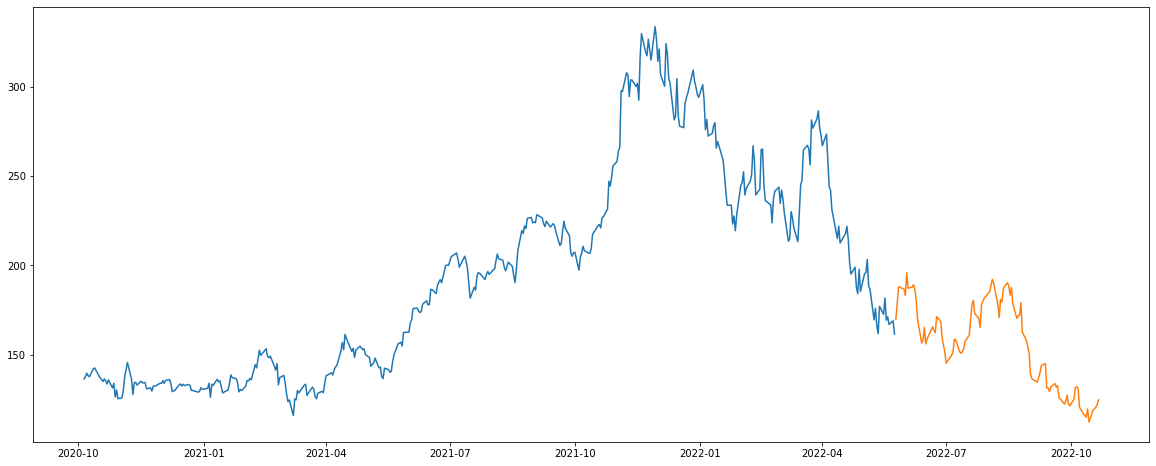

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

df = df.loc['2020-10-05':'2022-10-21']
n = int(len(df) * .8)
train = df['Close'][:n]
test = df['Close'][n:]

plt.plot(train)
plt.plot(test)

## ACF and PACF
- If the time series can be modelled by an ARIMA(p,d,0) model then we may use the PACF plot to determine the value of $p$ by identifying the last lag that is significant
- If the time series can be modelled by an ARIMA(0,d,q) model then we may use the ACF plot to determine the value of $q$ by identifying the last lag that is signficant

Conversely, if the time series can be modelled by an ARIMA(p,d,q) model then the ACF and PACF plot may provide little information on the relevant $p$ and $q$ values to take

We see that there is no such significant lags $q$ and $p$ in the ACF and PACF such that there are no significant lags after and conclude that the time series cannot be modelled by an ARIMA(p,d,0) or ARIMA(0,d,q) model

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


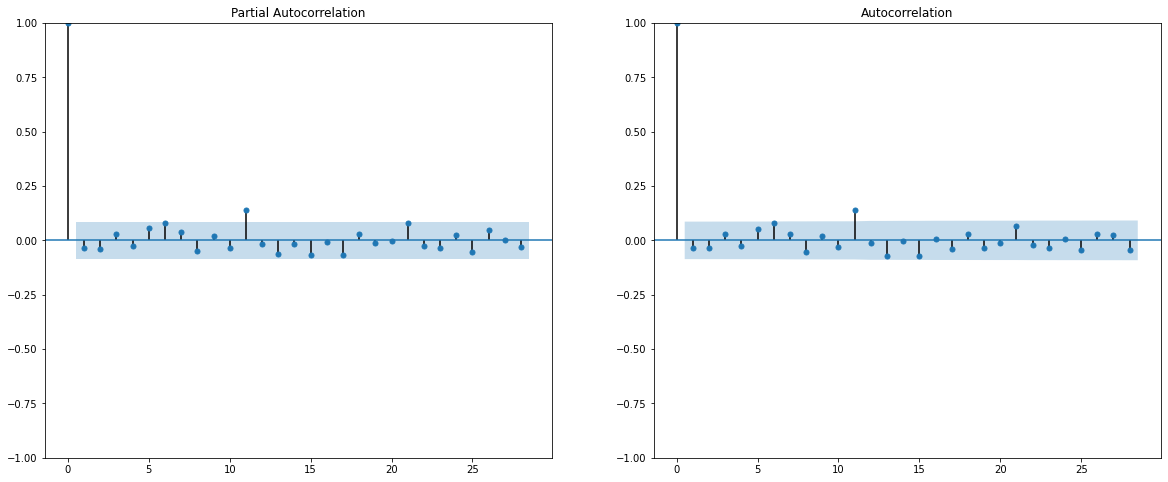

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
diff_df = df.diff().fillna(0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
plot_pacf(diff_df, ax=ax1)
plot_acf(diff_df, ax=ax2)
plt.show()

## Gridsearch for $p$ and $q$
As mentioned previously, we will be defining a gridsearch function to empirically find the best values of $p$ and $q$ for our time series
- Set $d$ to be $1$ then consider all possible combinations of $(p,1,q)$ values less than or equal to $10$ since fitting of models with a total sum of $p,d,q$ values greater than $10$ is computationally expensive
- For each model that is fitted to the data, we compute the Corrected Akaike's Information Criterion:
$$AIC_c=AIC+\frac{(p+q+k+1)(p+q+k+2)}{T-p-q-k-2}$$
- The order $(p,1,q)$ and its corresponding AICc are then added to a pandas Dataframe returned by the function

From the resultant dataframe, we select the order with the lowest corresponding AICc


In [ ]:
import itertools
import warnings
warnings.filterwarnings(action='once')
def AIC_PDQ(df):
  p = q = range(5)
  d = [1]
  pdq = list(itertools.product(p, d, q))
  ans = []
  for comb in pdq:
    try:
      model = ARIMA(df, order=comb)
      output = model.fit()
      ans.append([comb, output.aicc])
    except:
      continue
  ans_df = pd.DataFrame(ans, columns=['pdq', 'AICc'])
  print(ans_df.loc[ans_df['AICc'].idxmin()])
  return ans_df


In [ ]:
pdqs = AIC_PDQ(train)
ord = pdqs.loc[pdqs['AICc'].idxmin(), 'pdq']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq      (2, 1, 3)
AICc    2763.08226
Name: 13, dtype: object


## Walk-Forward Validation
Validation for the selected model is done in a walk-forward manner based on in sample forecasts:
1. Training set is used as the available past observations and a one-step forecast is carried out
2. The forecast $\hat y$ is compared to the actual observation $y$ in the test set for computation of root mean squared error
3. The actual observation $y$ is added to the available past observations and the steps 1 to 3 are repeated to derive forecasts for the entire test set

In [ ]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=ord)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 6.031


## Residual Diagnostics
A good forecasting method should have residuals that are uncorrelated. 
- If there are existing correlations in the residuals then there is still information present that could be considered by the model in making forecasts

Here, we use the ACF plot and Ljung-Box test to check for correlation between residuals
- In the ACF plot, majority of the lags are within the bounds of the ACF thus we can conclude that the plot of residuals resembles that of a white noise series
- In the Ljung-Box test, the p value is greater than 0.05 for varying values of lag thus there is insufficient evidence to reject the null hypothesis of the residuals being independent - note that the Ljung-Box test cannot prove independence but can be used to prove dependence 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


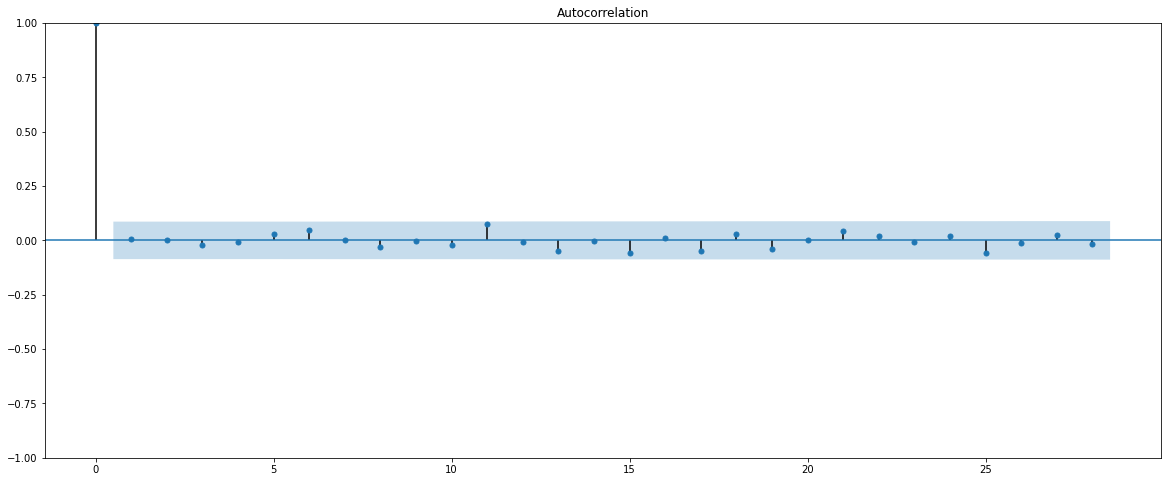

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.009112,0.923953,0.009059,0.924173
2,0.009700,0.995162,0.009643,0.995190
3,0.210796,0.975828,0.208801,0.976156
4,0.249398,0.992842,0.246957,0.992976
5,0.685116,0.983776,0.676799,0.984218
6,1.917229,0.927151,1.889919,0.929539
7,1.918210,0.964228,1.890884,0.965632
8,2.485501,0.962404,2.447244,0.964146
9,2.493252,0.981064,2.454831,0.982074
10,2.718177,0.987301,2.674555,0.988081


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = list()
model = ARIMA(df['Close'], order=ord).fit()
for i in range(len(test)): 
  residual = test[i] - predictions[i]
  residuals.append(residual)
plot_acf(model.resid)
plt.show()
acorr_ljungbox(model.resid, boxpierce=True)

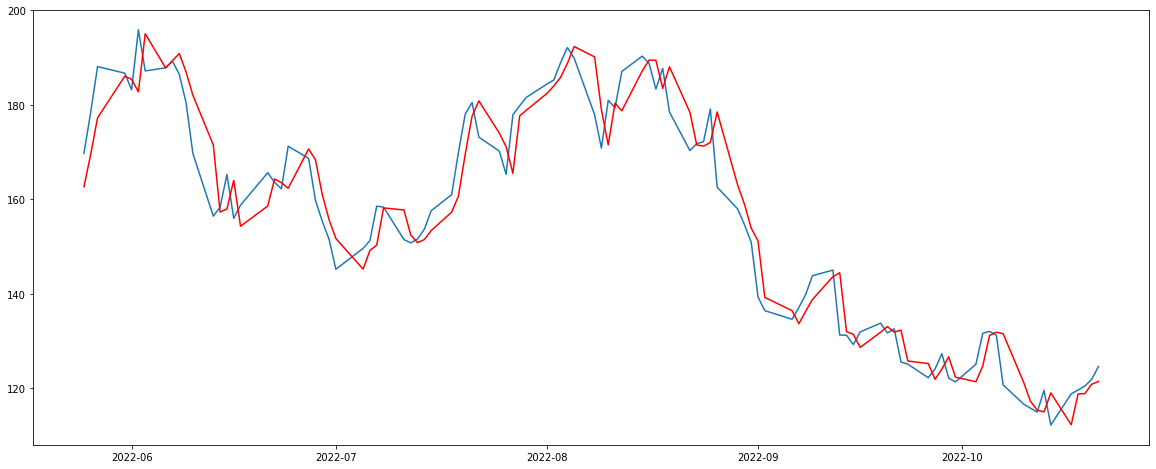

In [ ]:
plt.plot(test.index, test)
plt.plot(test.index, predictions, color='red')

## Out-of-sample Forecasts
We employ the use of an expanding window where the data from the past 3 years are initially passed to the model to make a one-step forecast into the future $\hat y_{t+1}$
- $\hat y_{t+1}$ is then added to the past observations to make the next one-step forecast $\hat y_{t+2}$
- The process is repeated to obtain the set of forecasts $y_{t+1}$ to $y_{t+10}$ which correspond to the predicted closing prices for 2022-10-24 to 2022-11-04

In [ ]:
data_so_far = [x for x in df['Close']]
close_for_next_10 = list()
for day in range(10):
  model = ARIMA(data_so_far, order=ord)
  model_fit = model.fit()
  output = model_fit.forecast()
  close_for_next_10.append(output[0])
  data_so_far.append(output[0])
ten_day_forecast = pd.DataFrame(close_for_next_10, columns=['Close'])
ten_day_forecast.index.name = 'Index'
ten_day_forecast.to_csv('Gavin_Goh_Jun_Chong_Impl_2.csv') 

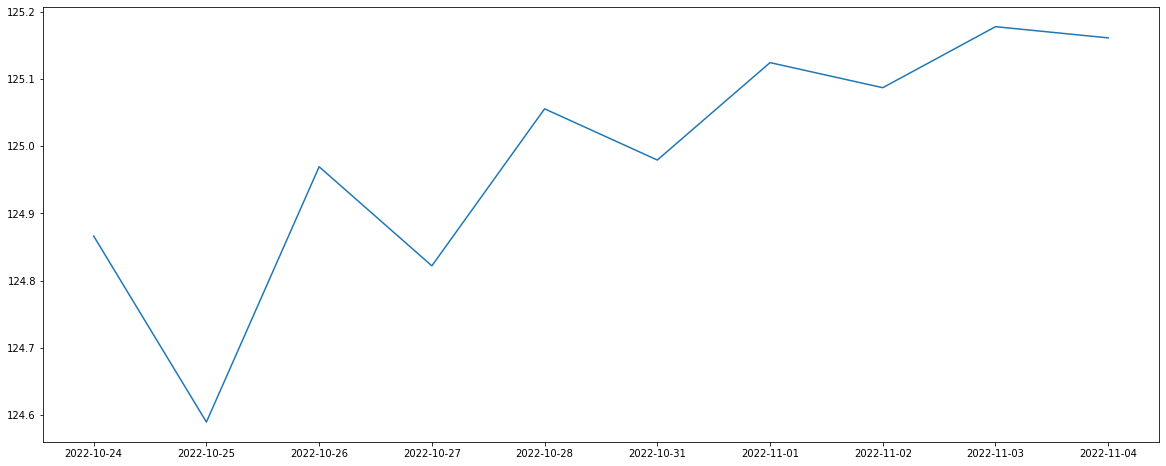

In [ ]:
next_10 = ['2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28',
           '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04']
plt.plot(next_10, ten_day_forecast)